# 2 Microscopic Traffic Simulation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import traci
import time
import xml.etree.ElementTree as ET

## 2.1 Model building and generate random vehicle input  


First, we need to generate random vehicle arrival that follows the poisson process. In this case, the arrival times are directly representing the time that the vehicle is loaded on the road. We assume that the arrival rate of vehicles is 3000/3600, meaning that there will be 3000 vehicles loading on the road in one hour. 
<!-- And we use the method that mentioned in th Sheldon M. Ross's simulation book to decide when to stop generate new vehicle. -->

[0.536313484952322, 0.9770211139033591, 0.8926612386790045, 1.0560369790020898, 0.9221578846828651, 1.7518032420159635, 4.6924673313710645, 3.0054043853969645, 3.6329518324986765, 1.7341909303973282, 0.38442625507496325, 0.46503230102137955, 0.06650636905359729, 1.590008553727837, 2.540557367414341, 1.8435897058588737, 2.651465996220126, 0.24401311225722533, 0.11375687212480037, 0.36407655221371044, 0.2493586584495676, 1.595582574341599, 3.0071667448736092, 1.2150582091147133, 0.44456439170218814, 0.4408865818307447, 3.431505878884566, 0.0986660887013344, 0.4702607586723587, 1.6139663706855025, 0.6362533573138385, 0.8693561933458257, 0.08466905429416434, 0.040137026081865756, 1.7601770477345526, 0.05484271562412652, 2.791113648737452, 0.7077460447247107, 2.278159690609446, 0.6903726844767092, 0.2114285456224136, 0.02494425463634884, 2.1271300513516995, 1.8233522880237094, 0.45277784296952805, 2.14396861148762, 0.7653009210242896, 1.6912585522941876, 0.13755306468588716, 2.5617142763612

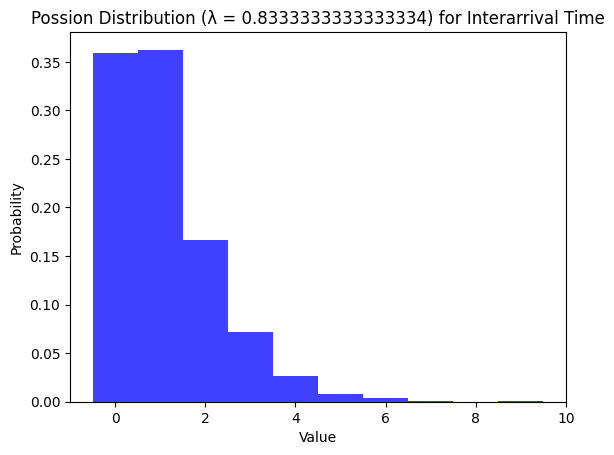

In [2]:
def generate_interarrival_time(lamda):
  start_time=0
  t = start_time

  u1 = np.random.random()
  t -= np.log(u1) / lamda
  
  return t

arrival_rate = 3000/3600  # Arrival rate of 3000 vehicles per hour


# Plot the histogram of multiple generated arrival time random variables
random_variable_size = 3000
interarrival_times = [generate_interarrival_time(arrival_rate) for _ in range(random_variable_size)]

print(interarrival_times)

# Plot the histogram of generated arrival time random variables
plt.hist(interarrival_times, bins=np.arange(min(interarrival_times), max(interarrival_times) + 1) - 0.5, density=True, alpha=0.75, color='b')
plt.title(f'Possion Distribution (λ = {arrival_rate}) for Interarrival Time')
plt.xlabel('Value')
plt.ylabel('Probability')
plt.show()

After generating the vehicles by python, we write them to the xml file called AH2174_2023_project1_section2.rou.xml. All these vehicles will go through from edge 1 to edge 5. We assume there are two types of vehicle. One is 'Car', its acceleration is 2.5 m/s2, its deceleration is 5m/s2, with a maximum speed as 40 m/s, and its vehicle legnth is 5 meters. Another one is 'Bus', its accelaration is 1.5 m/s2, its deceleration is 4 m/s2, with a maximum speed as 25 m/s, and it vehicle length is 18 meters. Both of them have IDM car follow model.

And we assign the vehicle type randomly to each vehicle. But considering that normally there will be more cars on the road, so we assume a vehicle 70 percent probability to be a car. 

In [83]:
def vehicle2file(interarrival_times):
    # Write arrivals to a file (e.g., sumo_test.arr.xml)
    with open('AH2174_2023_project1_section2.rou.xml', 'w') as f:
        f.write('<routes>\n')
        f.write('<vType accel="2.5" decel="5.0" id="Car" length="5.0" maxSpeed="40" sigma="0.0" carFollowModel="IDM"/>\n')
        f.write('<vType accel="1.5" decel="4.0" id="Bus" length="18.0" maxSpeed="25" sigma="0.0" carFollowModel="IDM" />\n')
        f.write('<route id="r1" edges="edge1 edge2 edge3 edge4 edge5"/>\n')

        depart_time=0 
        for num_vehicles,time in enumerate(interarrival_times):
            # the next arrival time is calculated by the last arrival time plus their interarrival time
            depart_time+=time

            vehicle_type = np.random.choice(['Car', 'Bus'], size=1,p=[0.7, 0.3])[0]
            f.write(f'<vehicle depart="{depart_time}" route="r1" id="{num_vehicles}" type="{vehicle_type}"/>\n')
        f.write('</routes>')

To check the number of vehicles loaded on the specific highway section in a SUMO simulation, we can use the traci module, which is the interface for interacting with a running SUMO simulation.  We need to query the vehicles that are currently present on the edges representing the highway section of interest.

In [48]:
traci.close()

In [51]:
# Start the SUMO simulation with your configuration file (e.g., sumo_test.sumocfg)
traci.start(["sumo", "-c", "AH2174_2023_project1_section2.sumo.cfg"])

# Run the simulation for a certain number of steps
i=1
simulation_steps = 4200

# Define the edges representing the highway section (e.g., edge1, edge2, etc.)
highway_edges = ["edge1", "edge2", "edge3", "edge4", "edge5"]
for _ in range(simulation_steps):
    traci.simulationStep()
    IDList = traci.vehicle.getIDList()
    # print the vehicle info when not empty
    if len(IDList):
        # Get the list of currently loaded vehicles on the highway section
        loaded_vehicles_on_highway = [v for v in IDList if traci.vehicle.getRoadID(v) in highway_edges]
        # Get the number of loaded vehicles on the highway section
        num_loaded_vehicles_on_highway = len(loaded_vehicles_on_highway)  
        print(i, IDList)
        print(f'Number of loaded vehicles on the highway section: {num_loaded_vehicles_on_highway}')
    i=i+1

traci.close()
print("SUMO simulation finished!")


5 ('0',)
Number of loaded vehicles on the highway section: 1
6 ('0',)
Number of loaded vehicles on the highway section: 1
7 ('0',)
Number of loaded vehicles on the highway section: 1
8 ('0', '1')
Number of loaded vehicles on the highway section: 2
9 ('0', '1')
Number of loaded vehicles on the highway section: 2
10 ('0', '1')
Number of loaded vehicles on the highway section: 2
11 ('0', '1', '2')
Number of loaded vehicles on the highway section: 3
12 ('0', '1', '2')
Number of loaded vehicles on the highway section: 3
13 ('0', '1', '2')
Number of loaded vehicles on the highway section: 3
14 ('0', '1', '2')
Number of loaded vehicles on the highway section: 3
15 ('0', '1', '2', '3')
Number of loaded vehicles on the highway section: 4
16 ('0', '1', '2', '3')
Number of loaded vehicles on the highway section: 4
17 ('0', '1', '2', '3')
Number of loaded vehicles on the highway section: 4
18 ('0', '1', '2', '3', '4')
Number of loaded vehicles on the highway section: 5
19 ('0', '1', '2', '3', '4')

We assume that there will be 3000 vehilces going through the highway in one hour. So we sonfigured simulation time to 3600 seconds, setting the begin time 0 and the end time 3600 in configutation file. And we let the simulation run 3600 steps, assuming that one step equals to one second in simulation context. We expecte that there will be 3000 vehicles loaded on the network after the simulation.

We print the vehicle ids and the number of vehilces loaded on the highway for each step during the simulation and save the vehicle simulation data in AH2174_2023_project1_section2_Vehicle_data.xml.

As the results shown in the printed data and the AH2174_2023_project1_section2_Vehicle_data.xml, we can observe that vehicles are dynamically entering and exiting the highway, which is expected in a traffic simulation. 

It is important to notice that vehicles might not be loaded onto the highway precisely at their scheduled departure times (in seconds). Most of the cases, vehicles are loaded slowlier than the depart time we set, if we look into the time value of timestep in vehicle_data.xml file. 

Vehicles that should be introduced at the same time are not instantaneously loaded at the same simulation step. There is a gradual introduction, and the loading of vehicles takes some simulation steps.

The number of loaded vehicles may depend on the total steps of the simulation. For instance, when the simulation steps were set to 3600, only approximately 997 vehicles were loaded. But when we extended the simulation duration to 4200 steps, about 1168 vehicls are loaded. 

In assumption, the time setting in configuration file (sumo.cfg) indicates the real time period that we want to simulate. The "simulation step" in Traci, however, might not perfectly align with real-time seconds. The simulation world may has its own clock and time. Each simulation step in python may stands for an amount of real world time. The step size can be the facotr in the speed of simulation. 

So, in our case, if we want to generate the total required 3000 vehicles in simulation, we can increase the number of simulation steps to run the simulation for a longer duratio, allowing more time for vehicles to enter the networkor. Alternatively, we can ajust the simulation step size to simulate each step as a longer time interval. 



## 2.2 Simulation output

To estimate and visualize average traffic speed in the simulated highway segments from edge 2 to edge 5 aggregated for a time interval of 5 minutes, we use dectetors to collect speed infomation of vehicls each 5 minutes. We put dectector on the middle of each lane of each edge from edge 2 to edge 5. During the simulation, these dectectors will record the infomation of each vehicle that passes through it. We can get the mean speed and the number of vehicls on the each lane every 5 minutes interval. And by calculating the sum speed of each lane and adding these speeds and dividing them by the total number of vehicles, we can get the average speed of edge segmants from 2 to 5 for every 5 minutes interval. In our code, the detectors are setting in AH2174_2023_project1_section2.add.xml file. And we saved the detecting result to xml files. 

  
In our code, we set a warmup step value as 600 in configuration file and python. And the simualtion time was defined as one hour. The warmup period will be excluded from the analysis period, ensuring that initial vehicle loading does not affect the average speed calculations. 

The vehicl model parameters are written above. 

In each simulation, we will regenerate new vehilces with new depart times that follows poisson process and collect the calculated average speed. At the end, we wil plot the traffic speed changes for all simulations.

In [53]:
# Function to parse the detector output XML file and extract speed data
def parse_detector_output(xml_file_path, warmup_duration=600):

    # Dictionary to store speed sum and vehicle number for each time interval
    speeds_sum = {}
    vehicles_sum={}

    for i in range(1,13):
        xml_file=xml_file_path+str(i)+'.xml'
        # print(xml_file)
        tree = ET.parse(xml_file)
        root = tree.getroot()       

        for interval in root.iter('interval'):
            time = float(interval.attrib['begin'])
            
            # Skip warmup duration
            if time < warmup_duration:
                continue

            # Extract mean speed and vehicle number for each interval    
            mean_speed = float(interval.attrib['speed'])
            vehicle_number = float(interval.attrib['nVehContrib'])
            speed_sum=mean_speed* vehicle_number 
            speeds_sum[time] = speeds_sum.get(time, 0) + speed_sum
            vehicles_sum[time] = vehicles_sum.get(time, 0) + vehicle_number

    # Calculate average speeds for each time interval
    average_speeds = {time: speeds_sum[time] / vehicles_sum[time] for time in speeds_sum}

    return average_speeds, speeds_sum, vehicles_sum

In [87]:
# Run the simulation for a certain number of steps
simulation_steps = 3600  
warmup_steps = 1000

# Number of simulation runs
num_simulations = 10

# Store the results of each simulation
all_simulation_results = []

# Specify the network file based on the scenario you want to run
network_file = f"AH2174_2023_project1_section2.net.xml"
configuration_file=f'AH2174_2023_project1_section2.sumo.cfg'


# Run multiple simulations with different random seeds
for run in range(num_simulations):
    # Choose a different random seed for each run
    random_seed = np.random.randint(1, 1000)
    # print(random_seed)    

    # generate the arrival time that follows the poisson process
    arrival_rate = 3000/3600  # Arrival rate of 3000 vehicles per hour
    random_variable_size = 3000
    interarrival_times = [generate_interarrival_time(arrival_rate) for _ in range(random_variable_size)]

    # generate the new rou.xml
    vehicle2file(interarrival_times)

    # Start the SUMO simulation with your configuration file
    traci.start(["sumo", "-c", configuration_file, "--net-file", network_file])

    for step in range(simulation_steps + warmup_steps):
      traci.simulationStep()
    
    traci.close()
    
    # File path to the detector output XML file
    xml_file_path = 'detector_output_'

    # Parse the XML file to get average speeds (excluding warmup)
    average_speeds, speeds_sum, vehicles_sum = parse_detector_output(xml_file_path,warmup_steps)

    all_simulation_results.append(average_speeds)


In [81]:
vehicles_sum

{1200.0: 336.0,
 1500.0: 330.0,
 1800.0: 336.0,
 2100.0: 307.0,
 2400.0: 312.0,
 2700.0: 333.0,
 3000.0: 329.0,
 3300.0: 349.0,
 3600.0: 357.0,
 3900.0: 333.0,
 4200.0: 330.0,
 4500.0: 106.0}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


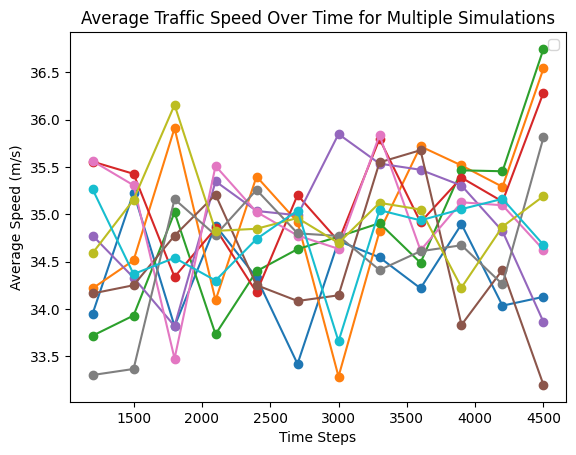

In [88]:
# Plot the results for each simulation run
for i, simulation_results in enumerate(all_simulation_results):
    time_intervals = list(simulation_results.keys())
    average_speed_values = list(simulation_results.values())

    plt.plot(time_intervals, average_speed_values, marker='o', linestyle='-')

plt.title('Average Traffic Speed Over Time for Multiple Simulations')
plt.xlabel('Time Steps')
plt.ylabel('Average Speed (m/s)')
plt.legend()
plt.show()

In [75]:
all_simulation_results

[{1200.0: 34.762215384615374,
  1500.0: 35.09495652173913,
  1800.0: 33.92123456790124,
  2100.0: 34.44671641791045,
  2400.0: 35.900644257703085,
  2700.0: 35.10401179941004,
  3000.0: 34.78846153846154,
  3300.0: 34.83573964497042,
  3600.0: 34.5986430678466,
  3900.0: 35.17564954682779,
  4200.0: 34.64791304347827,
  4500.0: 34.68085714285714},
 {1200.0: 34.45096273291925,
  1500.0: 35.23732954545454,
  1800.0: 36.436066481994466,
  2100.0: 33.689137380191696,
  2400.0: 35.294985835694035,
  2700.0: 34.3195625,
  3000.0: 36.18059782608697,
  3300.0: 35.39427762039661,
  3600.0: 34.92462686567164,
  3900.0: 34.5493175074184,
  4200.0: 34.32321766561515,
  4500.0: 32.95227722772277},
 {1200.0: 34.701721068249256,
  1500.0: 34.29826086956521,
  1800.0: 34.066840490797546,
  2100.0: 34.365582822085884,
  2400.0: 35.217303370786524,
  2700.0: 34.855073746312684,
  3000.0: 35.131445427728615,
  3300.0: 35.09923753665689,
  3600.0: 34.82098159509202,
  3900.0: 32.92253289473684,
  4200.0: 

As the results showen ont the plot, there are some variability and disperson in the results for each simulation run. And there are may be some factors that contribute to this kind of randomness:

1. Stochasticity in vehicle arrivals: Our vehicle arrivals follow a stochastic process. And we generate new random vehicle arrival times to initialize each simulation. It can introduce variability in traffic patterns. 

2. Randomness in driver behavior: We defined the car following model as IDM, leading to various driver behaviors. Different drivers with new gennerated vehicle parameters may exhibit varying behaviors in different simulation runs , affecting traffic flow.

## 2.3 Alternative scenario

To simulate the new scenario, we generate a new add.file (AH2174_2023_project1_Section2_alternativescenario.add.xml). In this new add.xml, the closure begin time of the two rightomost lanes is set to 1800, and the end time is set to 3540. And the speed limit during the lane closure is set to 30 km/h. 

And considering that the lane closure begins from 30 min after the simulation start, we set the warmup step to 1500, to manke sure the closure scenario is inlcuded in our analyasis.

netconvert --node-files AH2174_2023_project1_Section2.nod.xml --edge-files AH2174_2023_project1_Section2_alternativescenario.edge.xml -t AH2174_2023_project1_Section2.type.xml -o AH2174_2023_project1_Section2_alternativescenario.net.xml

Run Simulations:   
Run simulations for both the original and alternative scenarios. Each one with 10 simulation runs.

Collect Data:   
Extract relevant data from simulation outputs, including average speeds, traffic density.

Statistical Evaluation:  
1. Calculate and compare the changes of average traffic speeds on edge 4 for both scenarios. Average Traffic Speeds represent the average speed of vehicles on edge 4 over a given period. Its changes can indicate traffic congestion, revealing the efficency and flow of vehicles.
2. Analyze traffic density changes using occupancy or the number of vehicles on edge 4. Traffic density represents the number of vehicles occupying a specific legth of road (edge4). High traffic density can indicate traffic congestion, as more vehicles are runnging in the given space. It helps evaluate the capacity and usage of the road.

Plots:
Create plots to visually compare average speeds, traffic density, throughput, of the two scenarios over time.

In [147]:
# Function to parse the detector output XML file and extract speed data
def parse_detector_output_on_edge4(xml_file_path, warmup_duration=600):

    # Dictionary to store speed sum and vehicle number for each time interval
    speeds_sum_on_edge4 = {}
    vehicles_sum_on_edge4={}

    for i in range(7,10):
        xml_file=xml_file_path+str(i)+'.xml'
        # print(xml_file)
        tree = ET.parse(xml_file)
        root = tree.getroot()       

        for interval in root.iter('interval'):
            time = float(interval.attrib['begin'])
            
            # Skip warmup duration
            if time < warmup_duration:
                continue
            # Extract mean speed and vehicle number for each interval
            mean_speed_on_edge4 = float(interval.attrib['speed'])
            vehicle_number_on_edge4 = float(interval.attrib['nVehContrib'])
            speed_sum_on_edge4 = mean_speed_on_edge4 * vehicle_number_on_edge4
            speeds_sum_on_edge4[time] = speeds_sum_on_edge4.get(time, 0) + speed_sum_on_edge4
            vehicles_sum_on_edge4[time] = vehicles_sum_on_edge4.get(time, 0) + vehicle_number_on_edge4

    # Calculate average speeds for each time interval
    average_speeds_on_edge4 = {time: speeds_sum_on_edge4[time] / vehicles_sum_on_edge4[time] for time in speeds_sum_on_edge4}

    return average_speeds_on_edge4, speeds_sum_on_edge4, vehicles_sum_on_edge4

In [148]:
import pandas as pd
def simulation_scenario(network_file, configuration_file):
    # Run the simulation for a certain number of steps
    simulation_steps = 3600  
    warmup_steps = 1500

    # Store the results of each simulation for edge4
    all_simulation_results_edge4 = []

    edge4_length = 1000  # Adjust the length according to your network
    

    # Number of simulation runs
    num_simulations = 10

    # Run multiple simulations with different random seeds
    for run in range(num_simulations):
        # Choose a different random seed for each run
        # random_seed = np.random.randint(1, 1000)
        # print(random_seed)    

        # generate the arrival time that follows the poisson process
        arrival_rate = 3000/3600  # Arrival rate of 3000 vehicles per hour
        random_variable_size = 3000
        interarrival_times = [generate_interarrival_time(arrival_rate) for _ in range(random_variable_size)]

        # generate the new rou.xml
        vehicle2file(interarrival_times)

        # Start the SUMO simulation with your configuration file
        traci.start(["sumo", "-c", configuration_file, "--net-file", network_file])

        for step in range(simulation_steps + warmup_steps):
            traci.simulationStep()
        
        traci.close()
        
        # File path to the detector output XML file
        xml_file_path = 'detector_output_'

        # Parse the XML file to get average speeds (excluding warmup)
        average_speeds_edge4, speeds_sum_edge4, vehicles_sum_edge4 = parse_detector_output_on_edge4(xml_file_path, warmup_steps)

        # Calculate additional metrics specifically for edge4
        traffic_density_edge4 = {time: vehicles_sum_edge4[time] / edge4_length for time in vehicles_sum_edge4}
        # You may add more metrics as needed
        # Queue length can be obtained from detectors or waiting times
        # Add relevant calculations based on your specific requirements 

        # Store the results for this simulation run for edge4
        all_simulation_results_edge4.append({
            'average_speeds':  average_speeds_edge4,
            'traffic_density': traffic_density_edge4,
            # Include other metrics as needed
        })

    return all_simulation_results_edge4

In [149]:
def plot_simulation_results(all_simulation_results_edge4):
    # Plot the results for each simulation run for edge4
    for i, simulation_results_edge4 in enumerate(all_simulation_results_edge4):
        time_intervals_edge4 = list(simulation_results_edge4['average_speeds'].keys())
        average_speed_values_edge4 = list(simulation_results_edge4['average_speeds'].values())

        plt.plot(time_intervals_edge4, average_speed_values_edge4, marker='o', linestyle='-', label=f'Simulation {i + 1}')

    plt.title('Average Traffic Speed on edge4 Over Time for Multiple Simulations')
    plt.xlabel('Time Steps')
    plt.ylabel('Average Speed (m/s)')
    plt.legend()
    plt.show()

    # Plot traffic density for edge4
    for i, simulation_results_edge4 in enumerate(all_simulation_results_edge4):
        time_intervals_edge4 = list(simulation_results_edge4['traffic_density'].keys())
        traffic_density_values_edge4 = list(simulation_results_edge4['traffic_density'].values())

        # Plot traffic density over time for edge4
        plt.plot(time_intervals_edge4, traffic_density_values_edge4, marker='o', linestyle='-', label=f'Simulation {i + 1}')

    plt.title('Traffic Density Over Time for Edge4 in Multiple Simulations')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Traffic Density (vehicles/m)')
    plt.legend()
    plt.show()

In [153]:
def print_simulation_average_results(all_simulation_results_edge4):
    for i, simulation_results_edge4 in enumerate(all_simulation_results_edge4):
        time_intervals_edge4 = list(simulation_results_edge4['traffic_density'].keys())

    # Initialize dictionaries to store the sum of values for each time period
    sum_speeds = {time: 0 for time in time_intervals_edge4}
    sum_traffic_density = {time: 0 for time in time_intervals_edge4}

    # Calculate the sum of values for each time period
    for simulation_results_edge4 in all_simulation_results_edge4:
        for time, speed in simulation_results_edge4['average_speeds'].items():
            sum_speeds[time] += speed
        
        for time, density in simulation_results_edge4['traffic_density'].items():
            sum_traffic_density[time] += density

    # Calculate the average values for each time period
    num_simulations = len(all_simulation_results_edge4)
    average_speeds_edge4 = {time: sum_speeds[time] / num_simulations for time in time_intervals_edge4}
    average_traffic_density_edge4 = {time: sum_traffic_density[time] / num_simulations for time in time_intervals_edge4}

    # Create dataframes for average speeds, throughput, and traffic density
    df_speeds_edge4 = pd.DataFrame(average_speeds_edge4.items(), columns=['Time Steps', 'Average Speeds'])
    df_traffic_density_edge4 = pd.DataFrame(average_traffic_density_edge4.items(), columns=['Time Steps', 'Average Traffic Density'])

    # Merge dataframes on 'Time (seconds)'
    df_edge4 = pd.merge(df_speeds_edge4, df_traffic_density_edge4, on='Time Steps')

    # Print the table
    print("\nAverage Results for edge4:")
    print(df_edge4)

#### original scenario

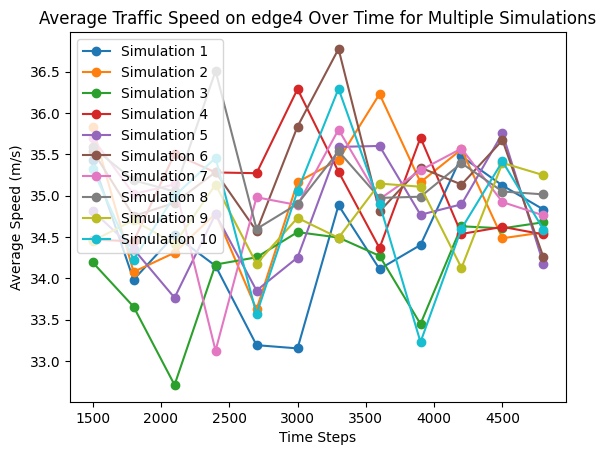

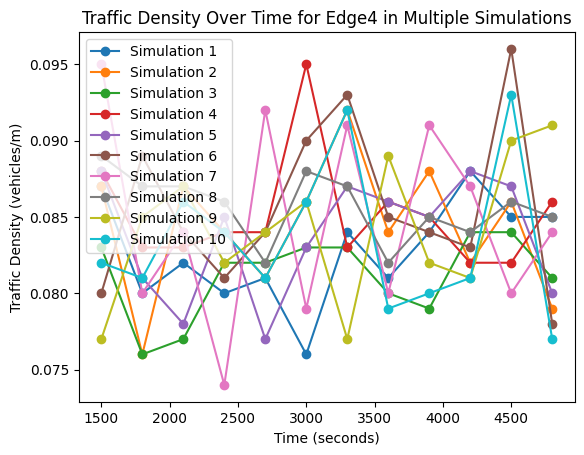


Average Results for edge4:
    Time Steps  Average Speeds  Average Traffic Density
0       1500.0       35.133884                   0.0856
1       1800.0       34.441166                   0.0818
2       2100.0       34.532794                   0.0835
3       2400.0       34.867014                   0.0822
4       2700.0       34.209316                   0.0828
5       3000.0       34.882660                   0.0852
6       3300.0       35.457732                   0.0869
7       3600.0       34.936810                   0.0832
8       3900.0       34.745784                   0.0843
9       4200.0       34.991936                   0.0840
10      4500.0       35.104012                   0.0869
11      4800.0       34.664276                   0.0826


In [154]:
# Specify the network file based on the scenario you want to run
network_file = f"AH2174_2023_project1_section2.net.xml"
configuration_file=f'AH2174_2023_project1_section2.sumo.cfg'

all_simulation_results_edge4=simulation_scenario(network_file, configuration_file)
plot_simulation_results(all_simulation_results_edge4)
print_simulation_average_results(all_simulation_results_edge4)

#### alternative scenario

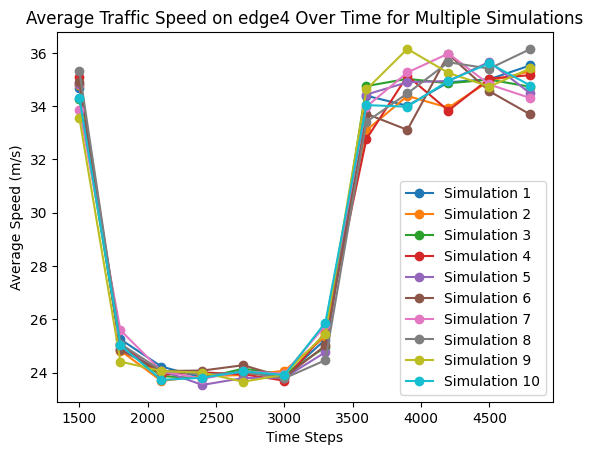

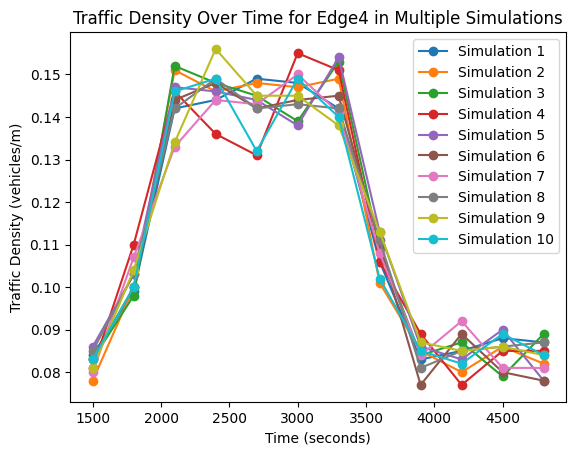


Average Results for edge4:
    Time Steps  Average Speeds  Average Traffic Density
0       1500.0       34.554852                   0.0824
1       1800.0       24.998762                   0.1024
2       2100.0       23.978000                   0.1437
3       2400.0       23.861000                   0.1466
4       2700.0       23.990000                   0.1421
5       3000.0       23.878000                   0.1458
6       3300.0       25.244621                   0.1455
7       3600.0       33.921513                   0.1079
8       3900.0       34.644776                   0.0841
9       4200.0       35.024482                   0.0845
10      4500.0       35.078509                   0.0850
11      4800.0       34.952981                   0.0835


In [155]:
# Specify the network file based on the scenario you want to run
network_file = f"AH2174_2023_project1_section2.net.xml"
configuration_file=f'AH2174_2023_project1_Section2_alternativescenario.sumo.cfg'

all_simulation_results_edge4=simulation_scenario(network_file, configuration_file)
plot_simulation_results(all_simulation_results_edge4)
print_simulation_average_results(all_simulation_results_edge4)

Describe Congestion Buildup:
Comment on how traffic congestion builds up along space and time in the simulation model for both scenarios.
Discuss the impact of the lane closure on vehicle behavior, and overall traffic flow.

Interpretation: 

By comparing the plots of different scenarios. In the original plots, all attributes experence similar and slight fluations over time. But in the alternative scenario: 

Average Traffic Speeds on Edge 4:  
A decrease in average traffic speeds on edge 4 over time indicates congestion. Slower speeds suggest that vehicles are experiencing delays. 

Traffic Density (Occupancy or Number of Vehicles) on Edge 4:  
An increase in traffic density, measured using occupancy or the number of vehicles on edge 4, suggests congestion. Higher density implies that more vehicles are present in a given space, potentially leading to reduced speeds and increased delays.  


In summary, a combination of vehicles changing lanes, speed restrictions, and drivers behaviors adjustments, collectively contributes to congestion on edge 4. 

Due to the closure of the two rightmost lanes and  a reduction in the speed limit to 30 km/h of the edge 4, all the following vehicles have to change their direction to drive on the only one available lane. This initiates a complex traffic dynamic where the flow of vehicles needs time to merge from three lanes to a single narrow lane, resulting in congestion and delays at the entrance of edge 4. 

The abrupt lane change requirement implies that drivers must adjust their trajectories, leading to traffic instability and interactions between different vehicles. Drivers may adopt a more cautious driving approach, causing a slowdown in traffic flow and irregular driving behavior. These changes can contribute to congestion at the entrance of edge 4 as vehicles strive to adapt to the new traffic conditions.

Simultaneously, limiting the speed to 30 km/h significantly reduces the efficiency of vehicle throughput. This speed limitation forces vehicles to spend more time on edge 4, exacerbating congestion.



